

# Get Data


In [0]:
import pandas as pd
import numpy as np
import io
from datetime import timedelta, date

In [0]:
# get the dates in between two dates
def daterange(start_date, end_date):
  """
  This function is used to get the dates between two dates
  Input:
  start_date: datetime
  end_date: datetime
  """
  for n in range(int((end_date - start_date).days)):
    yield start_date + timedelta(n)

In [0]:
# The data source is another github repository managed by JHU (Thank You JHU!!) 
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
start_date = date(2020,1,22)
end_date = date.today()

# read the csv files and create a time index
raw_data = []
time_index = []

try:
  for day in daterange(start_date,end_date):
      url = base_url + day.strftime("%m-%d-%Y")+".csv"
      raw_data.append(pd.read_csv(url))
      time_index.append(day)
except:
  pass

In [0]:
# create three dataframe for analysis purpose
columns = ['Confirmed','Deaths','Recovered']

US_df = pd.DataFrame(index=time_index, columns=columns)
NY_df = pd.DataFrame(index=time_index, columns=columns)
NYC_df = pd.DataFrame(index=time_index, columns=columns)

In [0]:
# Load all the data
for i in range(len(raw_data)):
  # get US data
  try:
    US_temp = raw_data[i][raw_data[i]['Country/Region']=='US']
  except:
    US_temp = raw_data[i][raw_data[i]['Country_Region']=='US']
  US_df.iloc[i]['Confirmed'] = US_temp['Confirmed'].sum()
  US_df.iloc[i]['Deaths'] = US_temp['Deaths'].sum()
  US_df.iloc[i]['Recovered'] = US_temp['Recovered'].sum()

  NY_Confirmed = 0
  NY_Deaths = 0
  NY_Recovered = 0

  # get NY state data
  for j in range(len(US_temp)):
    try:
      if 'NY' in US_temp.iloc[j]['Province/State'] or (US_temp.iloc[j]['Province/State'] == 'New York'):
        NY_Confirmed += US_temp.iloc[j]['Confirmed']
        NY_Deaths += US_temp.iloc[j]['Deaths']
        NY_Recovered += US_temp.iloc[j]['Recovered']
    except:
      NY_temp = US_temp[US_temp['Province_State'] == 'New York']
      NY_Confirmed = NY_temp['Confirmed'].sum()
      NY_Deaths = NY_temp['Deaths'].sum()
      NY_Recovered = NY_temp['Recovered'].sum()
      
  NY_df.iloc[i]['Confirmed'] = NY_Confirmed
  NY_df.iloc[i]['Deaths'] = NY_Deaths
  NY_df.iloc[i]['Recovered'] = NY_Recovered

  # get NYC data (data incomplete)
  try:
    NYC_df.iloc[i]['Confirmed'] = US_temp[US_temp['Admin2']=='New York City']['Confirmed'].sum()
    NYC_df.iloc[i]['Deaths'] = US_temp[US_temp['Admin2']=='New York City']['Deaths'].sum()
    NYC_df.iloc[i]['Recovered'] = US_temp[US_temp['Admin2']=='New York City']['Recovered'].sum()
  except:
    NYC_df.iloc[i]['Confirmed'] = 0
    NYC_df.iloc[i]['Deaths'] = 0
    NYC_df.iloc[i]['Recovered'] = 0


In [0]:
# save to csv file
US_df.to_csv('US_data.csv')
NY_df.to_csv('NY_data.csv')
NYC_df.to_csv('NYC_data.csv')

# Data Visualization

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
US_df['New Confirmed'] = US_df['Confirmed'].diff()
US_df['New Deaths'] = US_df['Deaths'].diff()
US_df['New Recovered'] = US_df['Recovered'].diff()

NY_df['New Deaths'] = NY_df['Deaths'].diff()
NY_df['New Confirmed'] = NY_df['Confirmed'].diff()
NY_df['New Recovered'] = NY_df['Recovered'].diff()

In [0]:
US_exNY_df = US_df - NY_df

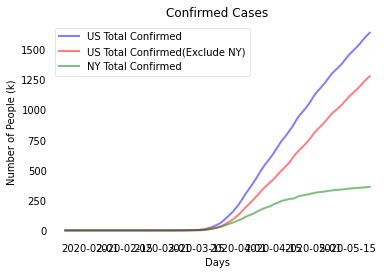

In [10]:
#t = list(range(len(time_index)))
t = time_index
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, US_df['Confirmed']/1000, 'b', alpha=0.5, lw=2, label='US Total Confirmed')
ax.plot(t, US_exNY_df['Confirmed']/1000, 'r', alpha=0.5, lw=2, label='US Total Confirmed(Exclude NY)')
ax.plot(t, NY_df['Confirmed']/1000, 'g', alpha=0.5, lw=2, label='NY Total Confirmed')
ax.set_xlabel('Days')
ax.set_ylabel('Number of People (k)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_title('Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

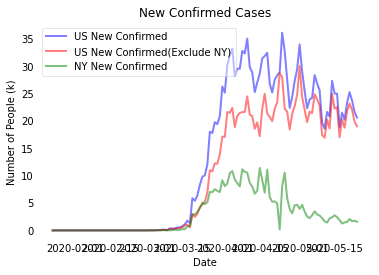

In [11]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, US_df['New Confirmed']/1000, 'b', alpha=0.5, lw=2, label='US New Confirmed')
ax.plot(t, US_exNY_df['New Confirmed']/1000, 'r', alpha=0.5, lw=2, label='US New Confirmed(Exclude NY)')
ax.plot(t, NY_df['New Confirmed']/1000, 'g', alpha=0.5, lw=2, label='NY New Confirmed')
ax.set_xlabel('Date')
ax.set_ylabel('Number of People (k)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_title('New Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# Gaussian Fitting

## US Excluding NY

In [0]:
from scipy.optimize import curve_fit

In [0]:
"""
based on the paper, define a gaussian function with three parameters

peak: peak value for the outbreak
mean: peak position
decay: the time duration between the peak and the time when new infections decreases to 1/e of the peak value

"""

def gaussian(t,peak,mean,decay):
  return peak*np.exp(-((t-mean)/decay)**2)

In [0]:
# fit the gaussian function
T = list(range(len(time_index)))
US_data = np.asarray(US_exNY_df['New Confirmed'][1:].astype(int))
us_init = [50000,40,100]
us_fit, us_var = curve_fit(gaussian,T[:-1],US_data,p0=us_init)

In [15]:
us_fit

array([25218.30183942,    97.4398978 ,    35.08833778])

In [0]:
t_extend = t.copy()
current = t[-1]

# for i in range(round(us_fit[2]).astype(int)):
#     current += timedelta(days=1)
#     t_extend = np.append(t_extend, current)

# T_extend = np.arange(len(t)+round(us_fit[2]).astype(int))


for i in range(round(100)):
    current += timedelta(days=1)
    t_extend = np.append(t_extend, current)

T_extend = np.arange(len(t)+round(100))

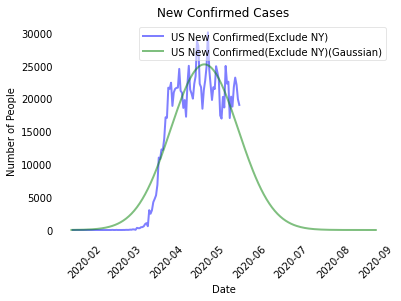

In [17]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, US_exNY_df['New Confirmed'], 'b', alpha=0.5, lw=2, label='US New Confirmed(Exclude NY)')
ax.plot(t_extend, gaussian(T_extend,us_fit[0],us_fit[1],us_fit[2]), 'g',alpha=0.5, lw=2, label='US New Confirmed(Exclude NY)(Gaussian)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of People')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation = 45)
ax.set_title('New Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

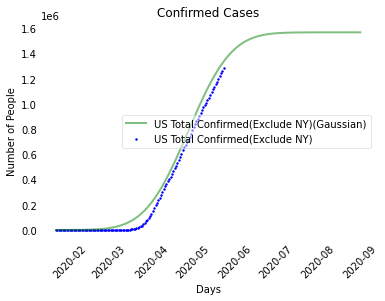

In [18]:
us_cum = np.cumsum(gaussian(T_extend,us_fit[0],us_fit[1],us_fit[2]))

# plot the result
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.scatter(t,US_exNY_df['Confirmed'],c='b',s=2,label='US Total Confirmed(Exclude NY)')
ax.plot(t_extend, us_cum, 'g', alpha=0.5, lw=2, label='US Total Confirmed(Exclude NY)(Gaussian)')
ax.set_xlabel('Days')
ax.set_ylabel('Number of People')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=45)
ax.set_title('Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## NY

In [0]:
# fit the gaussian function
NY_data = np.asarray(NY_df['New Confirmed'][1:].astype(int))
ny_init = [10000,50,100]
ny_fit, ny_var = curve_fit(gaussian,T[:-1],NY_data,p0=ny_init)

In [20]:
ny_fit

array([9465.12839279,   78.3966681 ,   21.14287194])

In [0]:
# t_extend = t.copy()
# current = t[-1]
# for i in range(round(ny_fit[2]).astype(int)):
#     current += timedelta(days=1)
#     t_extend = np.append(t_extend, current)

# T_extend = np.arange(len(t)+round(ny_fit[2]).astype(int))

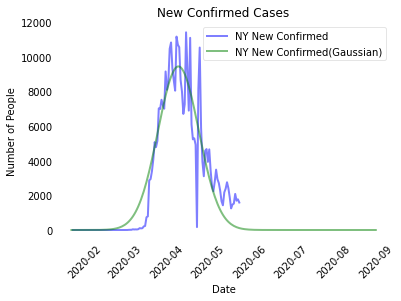

In [22]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, NY_df['New Confirmed'], 'b', alpha=0.5, lw=2, label='NY New Confirmed')
ax.plot(t_extend, gaussian(T_extend,ny_fit[0],ny_fit[1],ny_fit[2]), 'g',alpha=0.5, lw=2, label='NY New Confirmed(Gaussian)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of People')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation = 45)
ax.set_title('New Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

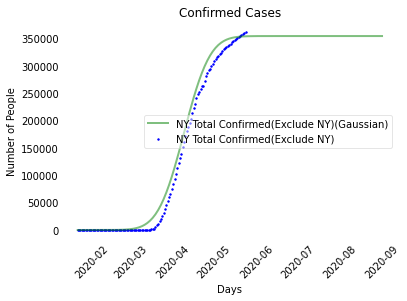

In [23]:
ny_cum = np.cumsum(gaussian(T_extend,ny_fit[0],ny_fit[1],ny_fit[2]))

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.scatter(t,NY_df['Confirmed'],c='b',s=2,label='NY Total Confirmed(Exclude NY)')
ax.plot(t_extend, ny_cum, 'g', alpha=0.5, lw=2, label='NY Total Confirmed(Exclude NY)(Gaussian)')
ax.set_xlabel('Days')
ax.set_ylabel('Number of People')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=45)
ax.set_title('Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# Kermack McKendrick Fitting

In [0]:
"""
the relationship derived from the paper is
I(t) = I(0)exp(t/tau_grow)
"""

# def KMK(t,I_0,tau_trans,tau_inf):
#   tau_grow = 1/(1/tau_trans - 1/tau_inf)
#   R_0 = tau_inf/tau_trans
#   p_inf = 1 - np.exp(-(R_0-1)/0.6)
#   tau_end = 1/(1/tau_inf - (1-p_inf)/tau_trans)
#   return I_0*np.exp(t/tau_grow)

def KMK(t,thres,I_0,tau_trans,tau_inf):
  tau_grow = 1/(1/tau_trans - 1/tau_inf)
  R_0 = tau_inf/tau_trans
  p_inf = 1 - np.exp(-(R_0-1)/0.6)
  tau_end = 1/(1/tau_inf - (1-p_inf)/tau_trans)
  # return I_0*np.exp(t/tau_grow)
  if len(t) <= thres:
    result = I_0*np.exp(t/tau_grow)
  else:
    result = I_0*np.exp(thres/tau_grow-(t-thres)/tau_end)
  return result

In [25]:
# US_infected = US_exNY_df['Confirmed']-US_exNY_df['Deaths']-US_exNY_df['Recovered']
# us_init = [18,0.52,1]
# us_kmk,us_var = curve_fit(KMK,T,US_infected.astype(int),p0=us_init)

US_infected = US_exNY_df['Confirmed']-US_exNY_df['Deaths']-US_exNY_df['Recovered']
us_init = [40,300,0.58,0.6]
us_kmk,us_var = curve_fit(KMK,T,US_infected.astype(int),p0=us_init)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [26]:
us_kmk

array([1.24798533e+02, 1.84821341e+04, 5.75821408e-01, 5.86910840e-01])

In [0]:
US_inf_diff = US_infected.diff()

In [0]:
US_data = np.asarray(US_inf_diff[1:].astype(int))
us_init = [30000,40,100]
us_fit, us_var = curve_fit(gaussian,T[1:],US_data,p0=us_init)
us_cum = np.cumsum(gaussian(T_extend,us_fit[0],us_fit[1],us_fit[2]))


In [32]:
us_fit

array([17589.21843279,    89.40500821,    29.53487032])

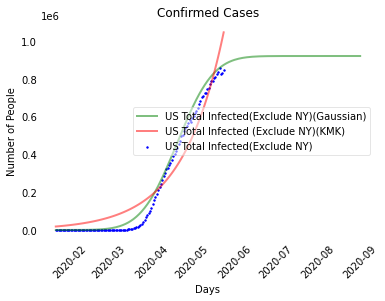

In [33]:
# plot the result
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.scatter(t,US_infected,c='b',s=2,label='US Total Infected(Exclude NY)')
ax.plot(t_extend, us_cum, 'g', alpha=0.5, lw=2, label='US Total Infected(Exclude NY)(Gaussian)')
ax.plot(t, KMK(T,us_kmk[0],us_kmk[1],us_kmk[2],us_kmk[3]), 'r', alpha=0.5, lw=2, label='US Total Infected (Exclude NY)(KMK)')
ax.set_xlabel('Days')
ax.set_ylabel('Number of People')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=45)
ax.set_title('Confirmed Cases')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [0]:
tau_inf = us_kmk[2]
tau_trans= us_kmk[1]
R_0 = tau_inf/tau_trans
p_inf = 1 - np.exp(-(R_0-1)/0.6)

In [35]:
p_inf

-4.294215136189146

In [36]:
R_0

3.11555691956654e-05

In [0]:
def Loss(data,T,thres,I_0,tau_trans,tau_inf):
  loss = 0
  init = [thres,I_0,tau_trans,tau_inf]
  tau_grow = 1/(1/tau_trans - 1/tau_inf)
  R_0 = tau_inf/tau_trans
  p_inf = 1 - np.exp(-(R_0-1)/0.6)
  tau_end = 1/(1/tau_inf - (1-p_inf)/tau_trans)
  for i in range(len(T)):
    if i <= thres:
      loss += (I_0*np.exp(i/tau_grow)-data[i])**2
    else:
      loss += np.abs((I_0*np.exp(thres/tau_grow-(i-thres)/tau_end) - data[i]))
  us_kmk,us_var = curve_fit(KMK,T,data,p0=init)
  # print(us_kmk,loss)
  return loss

In [0]:
thres_ = np.arange(20,75,5)
I_0_ = np.arange(250,460,10)
trans_ = np.arange(0.55,0.66,0.01)
inf_ = np.arange(0.55,0.66,0.01)
res = 0
min_ = np.inf
for a in thres_:
  for b in I_0_:
    for c in trans_:
      for d in inf_:
        # print(a,b,c,d)
        try:
          min_ = np.min(min_,Loss(US_infected,T,a,b,c,d))
          res = [a,b,c,d]
        except:
          continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_lau